## Import the necessary libraries

In [3]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tqdm
import os
import matplotlib.pyplot as plt

# specify the gpu to be utilized
os.environ["CUDA_VISIBLE_DEVICES"]="3"

## Load the test dataset

The following code defines a TensorFlow program that loads and processes a test dataset in the TensorFlow Record format.

1. The ``center_crop`` function is used to crop an image around the center to a specified size. The function takes an image tensor and the desired size as input, and returns the cropped image tensor.

2. The ``parser`` function is used to parse a single TensorFlow Record from the dataset. The function takes a single TensorFlow Record as input and returns the decoded anatomy and flow tensors.

3. The ``fldr`` variable defines the folder where the TensorFlow Record files are located. The tfrecord_paths variable is a list of the TensorFlow Record file paths in the folder.

4. The ``dataset_test`` variable is a TensorFlow Dataset that contains the TensorFlow Record files from the fldr folder. The dataset_test is processed using interleave and map functions to efficiently load and parse the TensorFlow Record files.

In [12]:
# image size
height_crop_size = 160 
width_crop_size = 64
slice_size = 64
batch_size = 1
# crop the enlarged images back to original size around the center
# This line of code is defining the center_crop function which takes two inputs, an image and a size. 
@tf.function
def center_crop(image, size):
    # This line of code checks if the size input is a tuple or a list. 
    # If it's not, the size is set to a list containing the size value twice. 
    if not isinstance(size, (tuple, list)):
        size = [size, size]
    # This line of code calculates the offset height value. 
    # The offset height is the difference between the height of the image and the desired height size, divided by 2.
    offset_height = (tf.shape(image)[-3]-size[0])//2
    # This line of code calculates the offset width value. 
    # The offset width is the difference between the width of the image and the desired width size, divided by 2.
    offset_width = (tf.shape(image)[-2]-size[1])//2
    # This line of code crops the image based on the calculated offset values and desired size values. 
    return tf.image.crop_to_bounding_box(image,offset_height,offset_width,size[0],size[1])


# Parse a single example from a tfrecord file
def parser(tfrecord):
    # Parse features from the tfrecord file
    feature = tf.io.parse_single_example(tfrecord,
                                          {'anatomy': tf.io.FixedLenFeature(shape=[], dtype=tf.string),
                                           'flow'  : tf.io.FixedLenFeature(shape=[], dtype=tf.string),
                                           'height': tf.io.FixedLenFeature(shape=[], dtype=tf.int64),
                                           'width' : tf.io.FixedLenFeature(shape=[], dtype=tf.int64),
                                           'depth' : tf.io.FixedLenFeature(shape=[], dtype=tf.int64)})
    # Convert height, width and depth from int64 to int32
    height = tf.cast(feature["height"], tf.int32)
    width  = tf.cast(feature["width"], tf.int32)
    depth  = tf.cast(feature["depth"], tf.int32)
    
    # Decode the anatomy feature from raw bytes to float32
    anatomy = tf.io.decode_raw(feature['anatomy'], tf.float32) 
    # Reshape the anatomy data to [height, width, depth]
    anatomy = tf.reshape(anatomy, [height, width, depth])
    # Crop the anatomy image
    anatomy = center_crop(anatomy, [height_crop_size,width_crop_size])
    
    # Decode the flow feature from raw bytes to float32
    flow = tf.io.decode_raw(feature['flow'], tf.float32) 
    # Reshape the flow data to [height, width, depth]
    flow = tf.reshape(flow, [height, width, depth])
    # Crop the flow image
    flow = center_crop(flow, [height_crop_size,width_crop_size])
    
    # Return the anatomy and flow images as a tuple
    return anatomy, flow


# set the directory to store the test data
fldr = 'test_data'

# get the path of test data files in the directory
tfrecord_paths = tf.io.gfile.glob(fldr+"/*test*")

# print the number of files in the test dataset
print(f"The test dataset is composed of {len(tfrecord_paths)} files:\n{tfrecord_paths}")

# create a dataset from the test data file paths
dataset_test = tf.data.Dataset.list_files(tfrecord_paths)

# interleave multiple test data files for parallel reading
dataset_test = dataset_test.interleave(lambda filename: tf.data.TFRecordDataset(filename),
                                         cycle_length=len(tfrecord_paths),
                                         num_parallel_calls=tf.data.AUTOTUNE)

# apply the parsing function to each data sample
dataset_test = dataset_test.map(map_func=parser, num_parallel_calls=tf.data.AUTOTUNE)

# group the samples into batches
dataset_test = dataset_test.batch(batch_size)

# calculate the number of batches
len_dataset = int(data_size/batch_size)
dataset_test = iter(dataset_test);

# print the size of the loaded training dataset
print(f"Size of the loaded test data set: {len_dataset} batches")

# create a list of the test dataset
data_test = [(anatomy, flow) for (anatomy, flow) in dataset_test]

The training dataset is composed of ['tfrecords\\bav_train.tfrecords', 'tfrecords\\ct2mri_train.tfrecords', 'tfrecords\\tav_train.tfrecords']
Size of the loaded training data set: 1095


## Generator and discriminator models

1. **Generator**
- **generator** is the 3D generator model for a convolutional neural network (CNN) using the functions encoder_layer and decoder_layer. The model has an input layer with a specified shape and applies multiple encoder and decoder layers to generate an output.
    - The function ``encoder_layer`` implements an encoder layer for a 3D Convolutional Neural Network (3D-CNN) model. It takes as input a feature map "x_con" and applies multiple 3D Convolution, Batch Normalization, and Leaky ReLU activation operations to produce a new feature map. The new feature map is concatenated with the input feature map, and this concatenation is fed as input to the next iteration of 3D Convolution, Batch Normalization, and Leaky ReLU. A pooling operation is optionally applied at the end of the encoding layer, which is specified by the ``pool`` argument. The pooling operation is an Average Pooling operation that reduces the spatial dimensions of the feature map by a factor of 2.

    - The ``decoder layer`` defines a generator decoder layer. The layer takes three inputs, input_, x, and ch, which represent the tensor to be upsampled, a tensor to concatenate with the upsampled tensor, and the number of channels, respectively. The layer performs a transposed convolution with filters equal to 20, kernel_size equal to [2,2,1], and strides equal to [2,2,1] to upsample input_. The upsampled tensor and x are then concatenated along the last axis.

2. **Discriminator**
- The ``downsample`` creates a 3D convolutional neural network (CNN) layer followed by batch normalization and leaky rectified linear unit (ReLU) activation is is used in the discriminator.

In [14]:
def encoder_layer(x_con, iterations, name, training, pool=True, filters=20, kernel_size=(3, 3, 3)):
    # assign x_con to x
    x = x_con
    # create batch normalization layer
    bn = tf.keras.layers.BatchNormalization()
    # create leaky relu layer
    relu = tf.keras.layers.LeakyReLU()
    # loop through the number of iterations
    for i in range(iterations):
        # apply 3D convolution layer with specified filters and kernel size, with padding "SAME"
        x = tf.keras.layers.Conv3D(filters, 
                                   kernel_size, 
                                   padding='SAME',
                                   name=f"conv_{i}")(x)
        # apply batch normalization to the output
        x = bn(x, training=training)
        # apply leaky relu activation to the output
        x = relu(x)
        # concatenate x and x_con along the last axis
        x_con = tf.concat([x, x_con], axis=-1)
    # if pool is True
    if pool:
        # apply average pooling with specified pool size and strides, and data format 'channels_last'
        pool = tf.keras.layers.AveragePooling3D(pool_size=(2, 2, 1), 
                                                strides=(2, 2, 1),
                                                data_format='channels_last')(x_con)
        # return both x_con and pool
        return x_con, pool
    # if pool is False
    return x_con
    # return only x_con


    
def decoder_layer(inputs, x, channels, name, upscale=(2, 2, 2), filters=20, kernel_size=(2, 2, 1)):
    with tf.name_scope(f"decoder_block_{name}"):
        # Upsample the input with a transposed convolution
        up = tf.keras.layers.Conv3DTranspose(filters=filters,
                                             kernel_size=kernel_size,
                                             strides=upscale,
                                             padding='SAME',
                                             name=f"upsample_{name}",
                                             use_bias=False)(inputs)
        # Concatenate the upsampled input with the other input `x`
        up = tf.concat([up, x], axis=-1, name=f"merge_{name}")
    return up

def generator():
    """
    Function to define the generator model of the CNN
    
    Returns:
    model (tf.keras.Model): The generator model
    """
    # Input layer with specified shape
    input_ = tf.keras.layers.Input(shape=[height_crop_size,width_crop_size,slice_size,1])
    
    # Encoder layers with specified iterations and name
    conv1, pool1 = encoder_layer(input_, iterations=2, name="encode_im1", training=True, pool=True)
    conv2, pool2 = encoder_layer(pool1, iterations=4, name="encode_im2", training=True, pool=True)
    conv3, pool3 = encoder_layer(pool2, iterations=6, name="encode_im3", training=True, pool=True)
    conv4 = encoder_layer(pool3, iterations=8, name="encode_im4", training=True, pool=False)
    
    # Decoder layers with specified name
    up1 = decoder_layer(conv4, conv3, 10, name=12)
    conv7 = encoder_layer(up1, iterations=6, name="conv_im6", training=True, pool=False)
    up2 = decoder_layer(conv7, conv2, 8, name=21)
    conv8 = encoder_layer(up2, iterations=4, name="encode_im7", training=True, pool=False)
    up3 = decoder_layer(conv8, conv1, 6, name=32)
    conv9 = encoder_layer(up3, iterations=2, name="encode_im8", training=True, pool=False)
    
    # Final Conv3D layer
    conv10 = tf.keras.layers.Conv3D(1, (1,1,1), name='logits_re_im', padding='SAME')(conv9)
    
    # Model definition
    model = tf.keras.Model(inputs=input_, outputs=conv10)
    
    return model


# disciminator downsampler
def downsample(filters, size, apply_batchnorm=True):
    """
    Function to create a downsampling layer in the generator network
    
    Parameters:
    filters (int): Number of filters in the Conv3D layer
    size (int): The size of the Conv3D layer
    apply_batchnorm (bool, optional): If True, adds BatchNormalization layer after Conv3D. Defaults to True.
    
    Returns:
    result (tf.keras.Sequential): The downsampling layer
    """
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    
    # Conv3D layer with specified number of filters and kernel size
    result.add(tf.keras.layers.Conv3D(filters, kernel_size=[3,3,3], padding='same',
                                      kernel_initializer=initializer))
    
    # Optional BatchNormalization layer and leaky ReLU activation
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        result.add(tf.keras.layers.LeakyReLU())
    
    return result

def discriminator():
    # Initialize a random normal initializer with mean 0 and standard deviation 0.02
    initializer = tf.random_normal_initializer(0., 0.02)
    
    # Create an input layer for the input image with shape [height_crop_size, width_crop_size, slice_size, 1]
    inp = tf.keras.layers.Input(shape=[height_crop_size, width_crop_size, slice_size, 1],
                                name='input_image')
    
    # Create an input layer for the target image with shape [height_crop_size, width_crop_size, slice_size, 1]
    tar = tf.keras.layers.Input(shape=[height_crop_size, width_crop_size, slice_size, 1],
                                name='target_image')
    
    # Concatenate the input and target images
    x = tf.keras.layers.concatenate([inp, tar])
    
    # Apply the downsample function with 16 filters and a kernel size of 2, and no batch normalization
    down1 = downsample(16, 2, False)(x)
    
    # Apply the downsample function with 32 filters and a kernel size of 2, and batch normalization
    down2 = downsample(32, 2)(down1)
    
    # Apply the downsample function with 64 filters and a kernel size of 2, and batch normalization
    down3 = downsample(64, 2)(down2)
    
    # Apply a zero padding layer to down3
    zero_pad1 = tf.keras.layers.ZeroPadding3D()(down3)
    
    # Apply a Conv3D layer with 128 filters and a kernel size of 4, and stride of 1
    conv = tf.keras.layers.Conv3D(128, 4, strides=1, padding='SAME')(zero_pad1)
    
    # Apply a batch normalization layer to the output of the Conv3D layer
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    
    # Apply a leaky ReLU activation layer to the output of the batch normalization layer
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    
    # Apply a zero padding layer to the output of the leaky ReLU activation layer
    zero_pad2 = tf.keras.layers.ZeroPadding3D()(leaky_relu)
    
    # Apply a Conv3D layer with 1 filter and a kernel size of 4, and stride of 1
    last = tf.keras.layers.Conv3D(1, 4, strides=1, padding='SAME')(zero_pad2)
    
    # Return a Model with input layers [inp, tar] and output layer `last`
    return tf.keras.Model(inputs=[inp, tar], outputs=last)

## Bland-Altman Limits of Agreement (LOA)

A Bland-Altman plot (also known as a difference plot) is a graphical method for comparing two measurements techniques. It is often used to assess the agreement between two methods of measurement. The plot is a scatter plot of the difference between the two measurement methods against the average of the two methods. The plot is used to visualize the mean difference and the limits of agreement between the two methods. The limits of agreement are defined as the mean difference ± 1.96 standard deviations of the differences, and are used as a measure of the agreement between the two methods. The plot is used to detect any systematic bias or proportional error between the two methods.

- We will restore the model at different training checkpoints and calculate the limits of agreement

In [112]:
output_dir = './haben_output'
checkpoint_dir = tf.io.gfile.join(output_dir, 'training_checkpoints')

# Instantiate the generator and discriminator models
gen = generator() 
disc = discriminator() 

# test setp
def test_step(gen, anatomy):
    anatomy2flow = gen(anatomy)
    return anatomy2flow


# Get a list of all checkpoint files in the folder
checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith('ckpt-')]

# Sort the checkpoint files by their number
checkpoint_files.sort(key=lambda x: int(x.split('-')[1]))

# Create a checkpoint object to save and restore the model's weights
checkpoint = tf.train.Checkpoint(gen_optimizer=gen_optimizer,
                                 disc_optimizer=disc_optimizer,
                                 gen=gen,
                                 disc=disc)

# Create an array to store the limits of agreement (loa) for each checkpoint
loa = np.zeros(shape=(len(checkpoint_files), len(Asample)))

# Create an array to store bias for each checkpoint
bias = np.zeros(shape=(len(checkpoint_files), len(Asample)))

# Iterate over the checkpoints
for ii, ckpt_file in enumerate(checkpoint_files):
    # Create the checkpoint path by concatenating the checkpoint directory and the current checkpoint filename
    checkpoint_path = tf.io.gfile.join(checkpoint_dir, ckpt_file)
    # Restore the model's weights from the checkpoint
    checkpoint.restore(checkpoint_path)
    print(f"Checkpoint: {checkpoint_path} is restored")
    for jj, (A, B) in enumerate(dataset_test):
        # Reshape the input images A and B to the model's expected shape
        A = tf.reshape(A, (1, height_crop_size, width_crop_size, slice_size, 1))
        B = tf.reshape(B, (1, height_crop_size, width_crop_size, slice_size, 1))
        # Generate the transformed image A2B
        A2B = test_step(gen, A)
        # Convert the tensors to numpy arrays and remove the extra dimensions
        B = np.squeeze(B.numpy())
        A2B = np.squeeze(A2B.numpy()) 
        # Remove the zero values
        Bcopy = B
        B = B[np.unique(np.where(B != 0)[0]), :, :]
        B = B[:, np.unique(np.where(B != 0)[1]), :]
        B = B[:, :, np.unique(np.where(B != 0)[2])]
        A2B = A2B[np.unique(np.where(Bcopy != 0)[0]), :, :]
        A2B = A2B[:, np.unique(np.where(Bcopy != 0)[1]), :]
        A2B = A2B[:, :, np.unique(np.where(Bcopy != 0)[2])]
        # Calculate the difference between the two measures
        diff = B-A2B
        # Calculate the mean difference and standard deviation of the differences
        mean_diff = np.mean(diff)
        std_diff = np.std(diff)
        # Caculate the bias
        bias[ii][jj] = mean_diff
        # Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of the differences)
        loa[ii][jj] = mean_diff + 1.96 * std_diff

Checkpoint: .\haben_output\training_checkpoints_modified_lr_2\ckpt-1 is restored
Checkpoint: .\haben_output\training_checkpoints_modified_lr_2\ckpt-2 is restored
Checkpoint: .\haben_output\training_checkpoints_modified_lr_2\ckpt-3 is restored
Checkpoint: .\haben_output\training_checkpoints_modified_lr_2\ckpt-4 is restored
Checkpoint: .\haben_output\training_checkpoints_modified_lr_2\ckpt-5 is restored
Checkpoint: .\haben_output\training_checkpoints_modified_lr_2\ckpt-6 is restored
Checkpoint: .\haben_output\training_checkpoints_modified_lr_2\ckpt-7 is restored
Checkpoint: .\haben_output\training_checkpoints_modified_lr_2\ckpt-8 is restored
Checkpoint: .\haben_output\training_checkpoints_modified_lr_2\ckpt-9 is restored
Checkpoint: .\haben_output\training_checkpoints_modified_lr_2\ckpt-10 is restored
Checkpoint: .\haben_output\training_checkpoints_modified_lr_2\ckpt-11 is restored
Checkpoint: .\haben_output\training_checkpoints_modified_lr_2\ckpt-12 is restored
Checkpoint: .\haben_outpu

## Plot the bias and limits of agreement versus the epochs

**Bias** in the Bland-Altman plot is the average of the difference between the two sets of measuremens: ```bias = mean(m1-m2)```

**LOA** or limits of agreement is calculated as the bias $\pm$ 1.96 times the standard deviation. The limits of agreement can be interpreted as the range in which 95% of the differences between the two sets of measurements are expected to fall.: ```LOA = bias+1.96*std(m1-m2)``` 

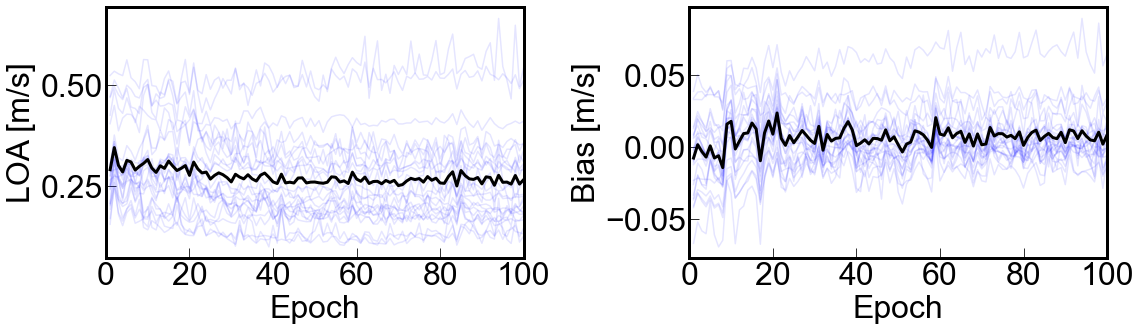

In [113]:
# Set font properties
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 20

# Create the figure and axis objects
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Loop over the subplots
for counter, ax1 in enumerate(axs):
    if counter == 0:
        y = loa
        ylabel = 'LOA [m/s]'
    else: 
        y = bias
        ylabel = 'Bias [m/s]'
    # Calculate the mean of each column 
    mean = np.mean(y, axis=1)

    # Plot each column with transparency
    for i in range(y.shape[1]):
        ax1.plot(range_list, y[:,i], alpha=0.1, color='blue')

    # Plot the mean line on top in black color
    ax1.plot(range_list, mean, linewidth=3, color='black')

    # Set axis labels and plot box line width
    ax1.set_xlabel('Epoch', fontname='arial', fontsize=32)
    ax1.set_ylabel(ylabel, fontname='arial', fontsize=32)

    # Set the y-axis scale to logarithmic
    ax1.set_yscale('linear')

    # set the x-axis limits
    ax1.set_xlim(range_list[0],range_list[-1])

    # set the x-axos ticks
    ax1.set_xticks(np.arange(0,110,20),np.arange(0,110,20))

    # set the tick properties
    ax1.tick_params(which='both', direction='in', length=10, labelsize=32)

    # Set the width of the plot box
    ax1.spines["top"].set_linewidth(3)
    ax1.spines["right"].set_linewidth(3)
    ax1.spines["bottom"].set_linewidth(3)
    ax1.spines["left"].set_linewidth(3)

# Show the plot
fig.tight_layout()
plt.show()
fldr = r'C:\Users\mem1342\OneDrive - Northwestern University\meetings\2023_jan_30_individualMeeting'
fig.savefig(tf.io.gfile.join(fldr,'LOA_Bias_vs_epochs_nonzero.svg'), bbox_inches='tight',facecolor=fig.get_facecolor())


## Show example images at different epochs

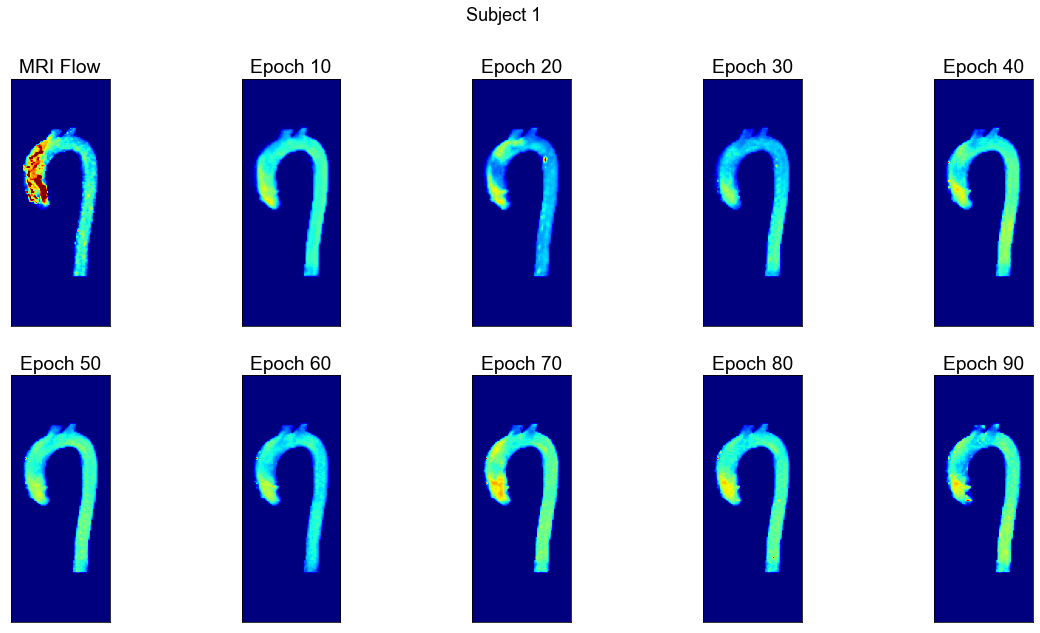

----------------------------------------------------------


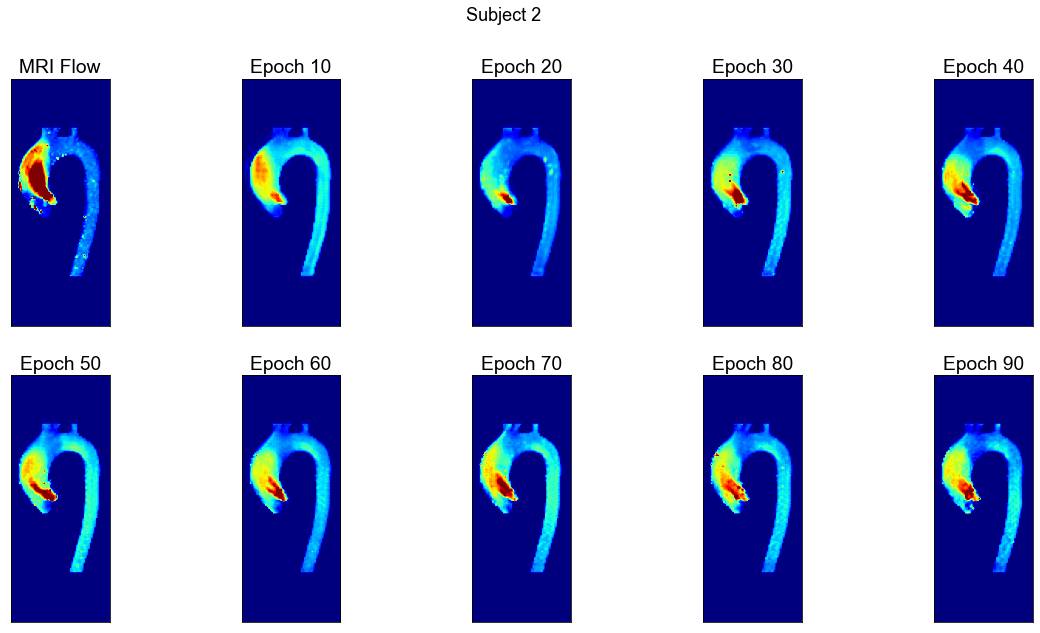

----------------------------------------------------------


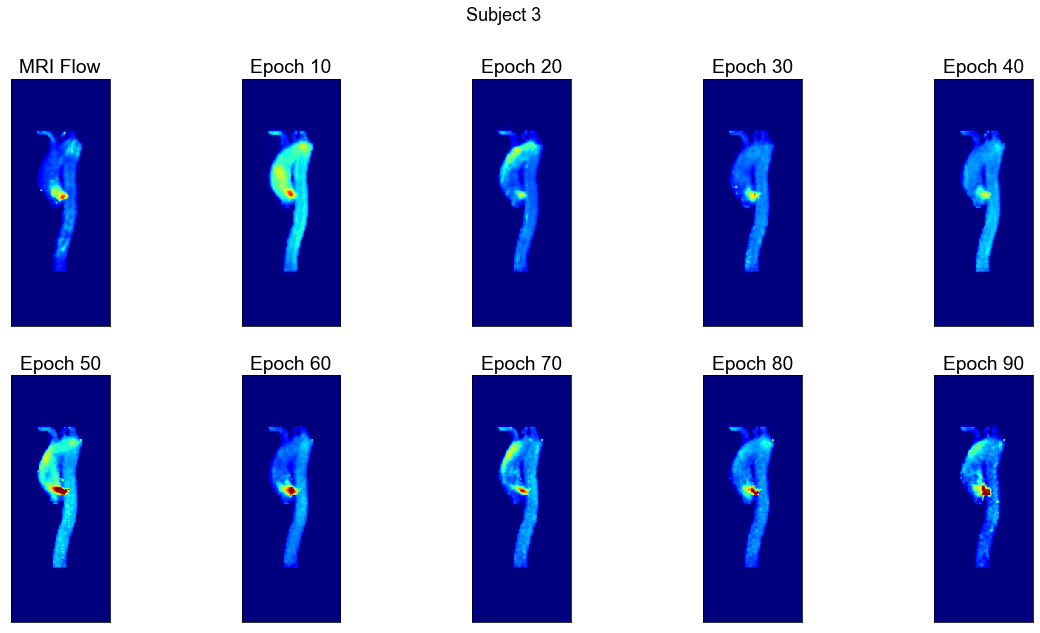

----------------------------------------------------------


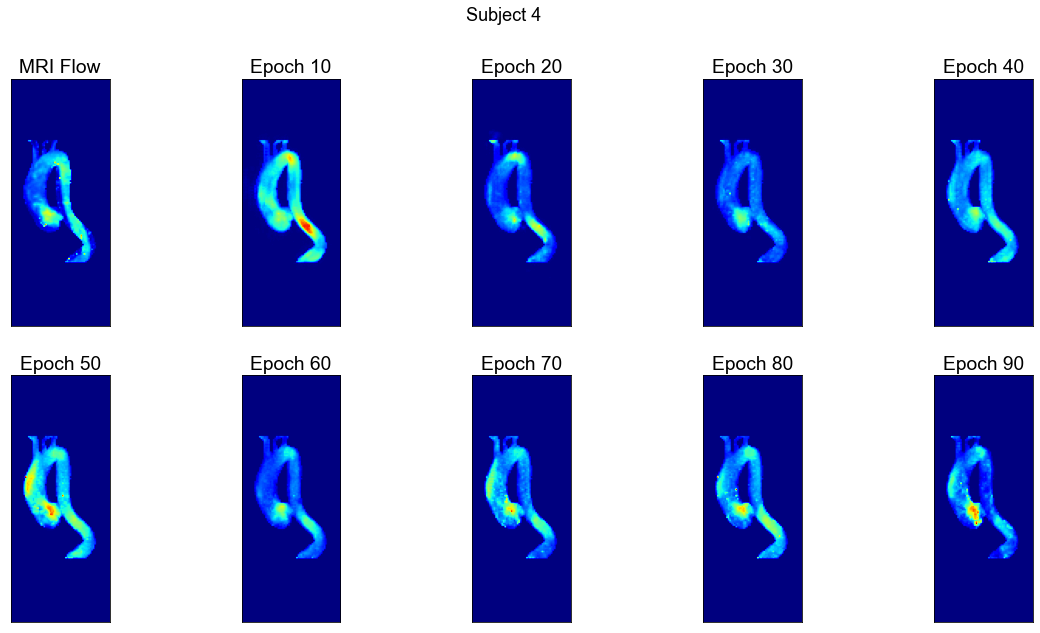

----------------------------------------------------------


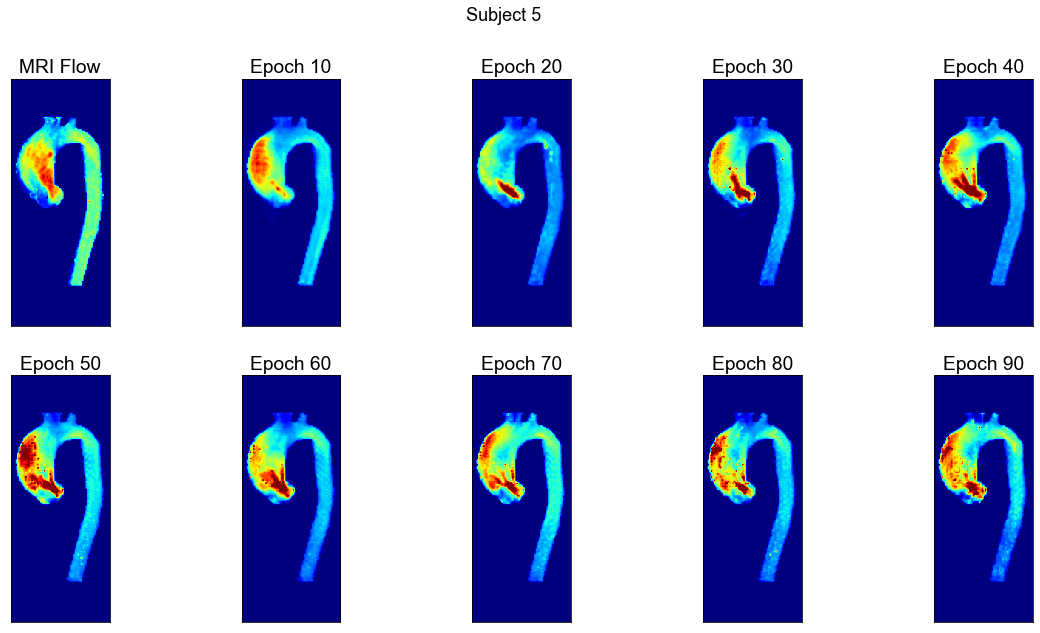

----------------------------------------------------------


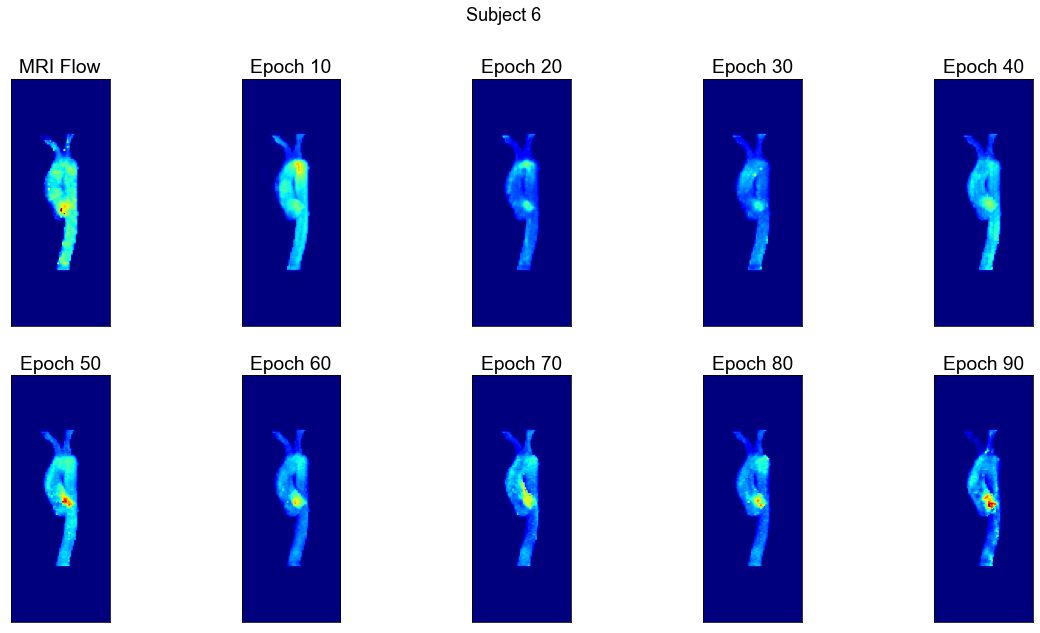

----------------------------------------------------------


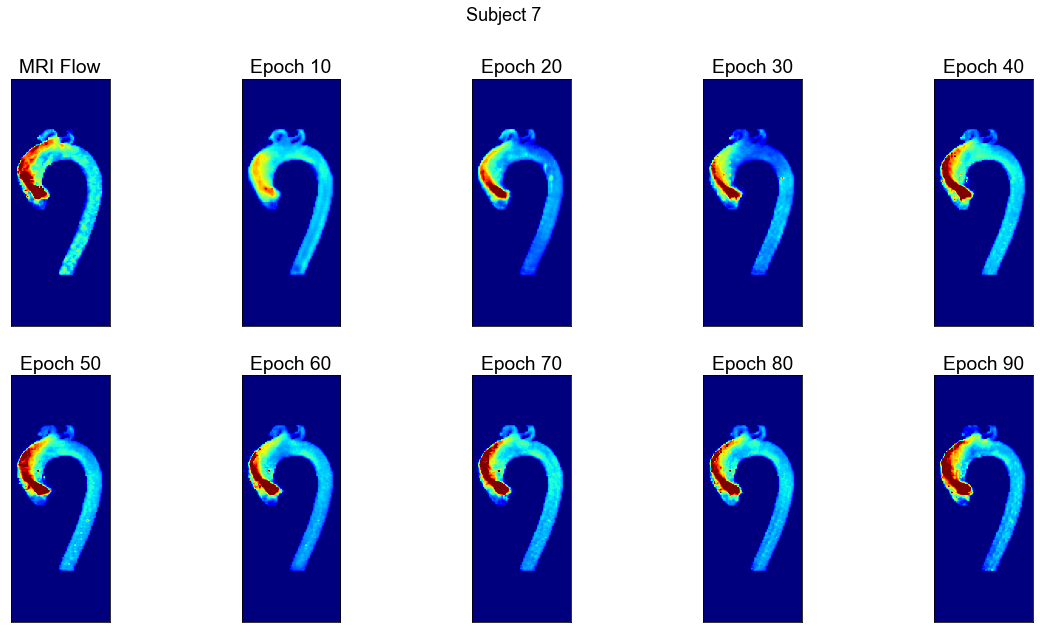

----------------------------------------------------------


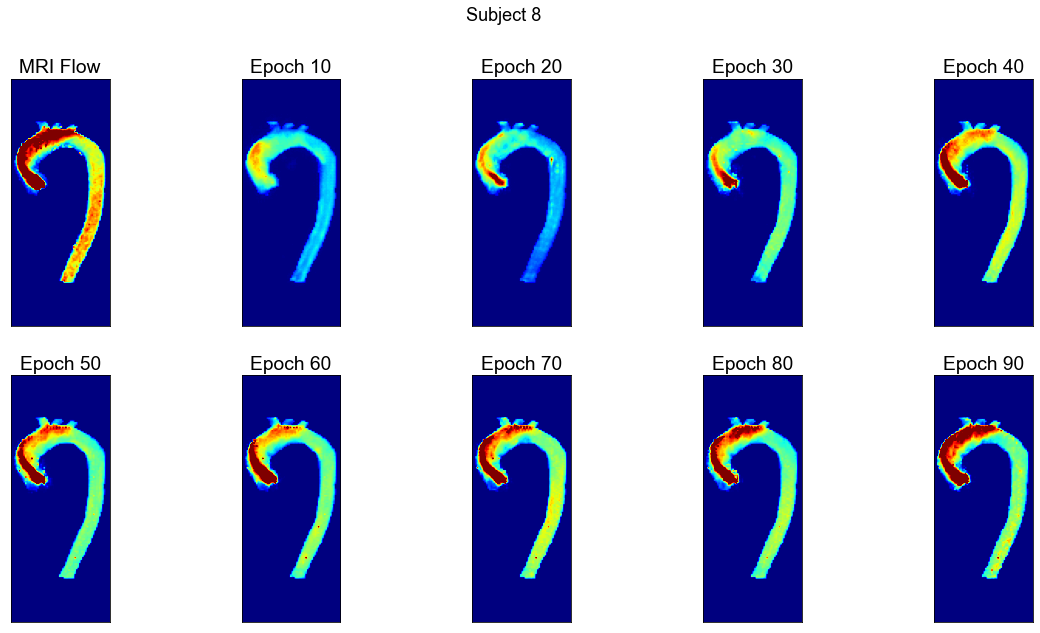

----------------------------------------------------------


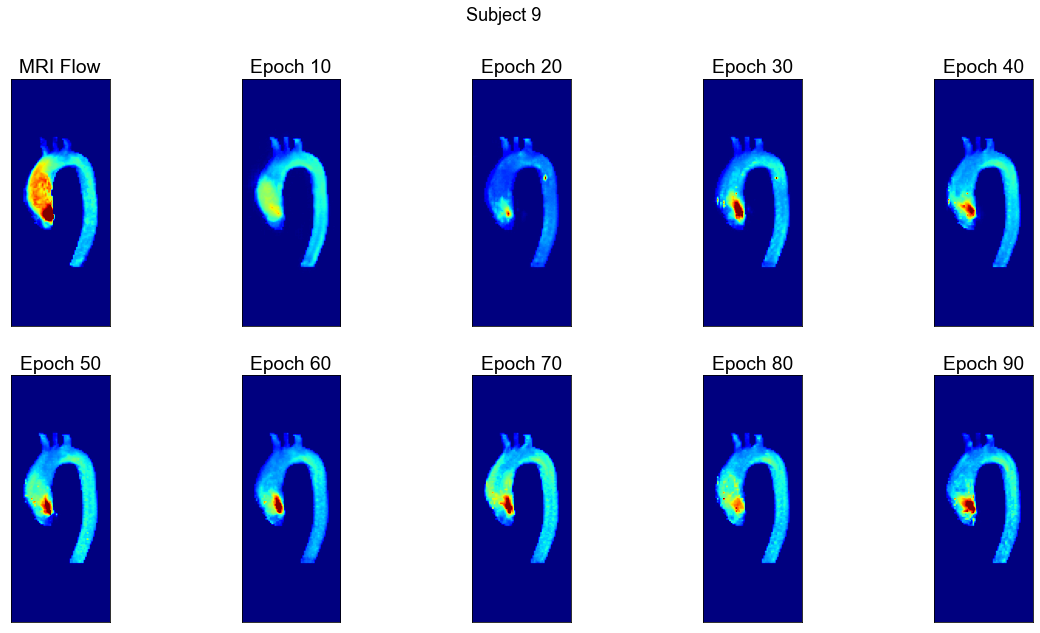

----------------------------------------------------------


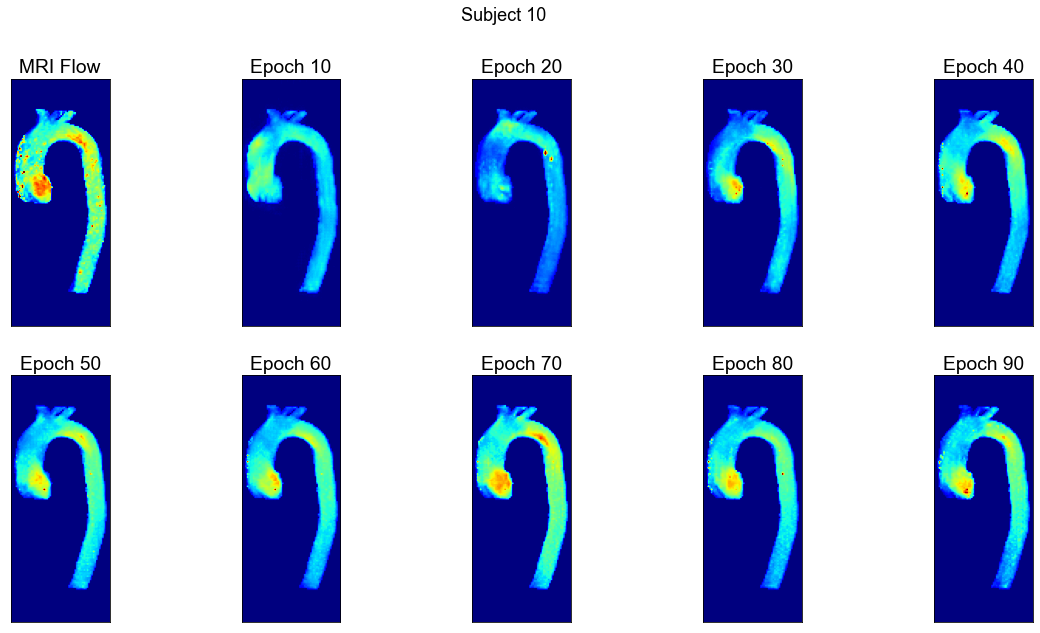

----------------------------------------------------------


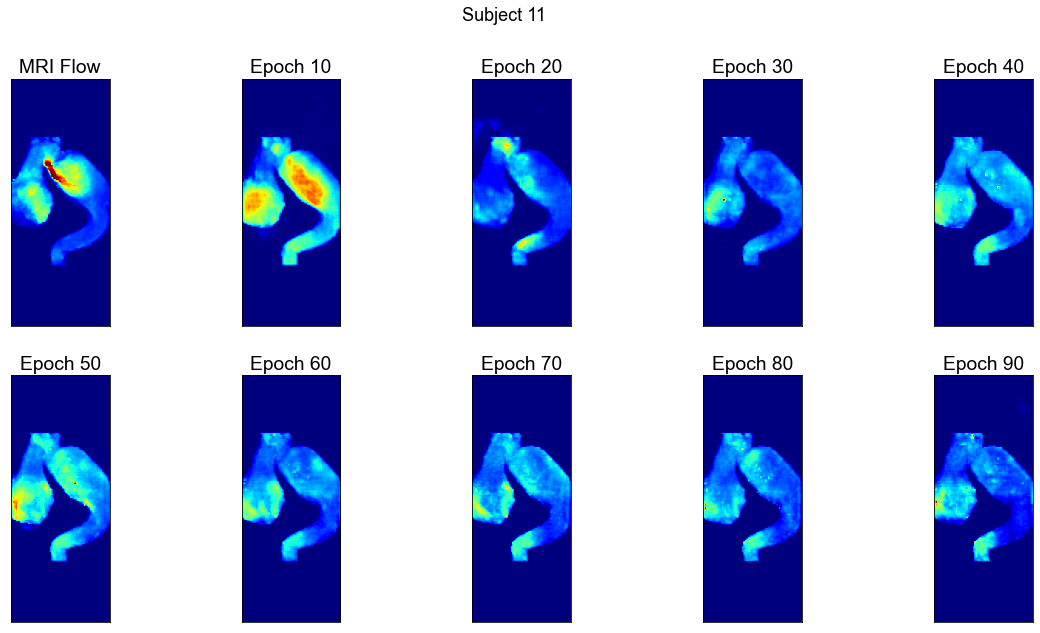

----------------------------------------------------------


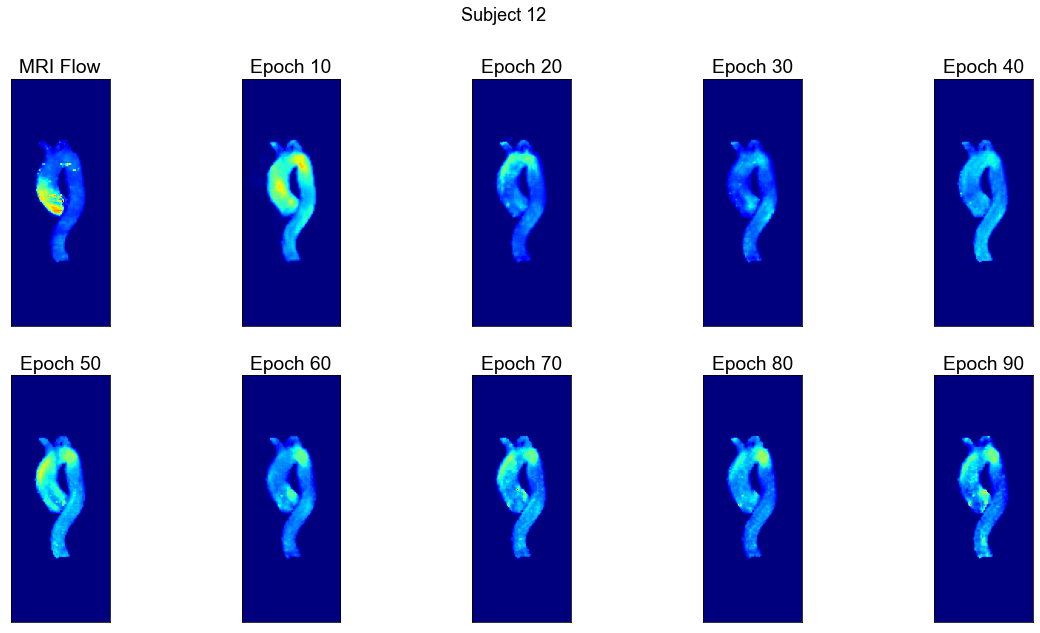

----------------------------------------------------------


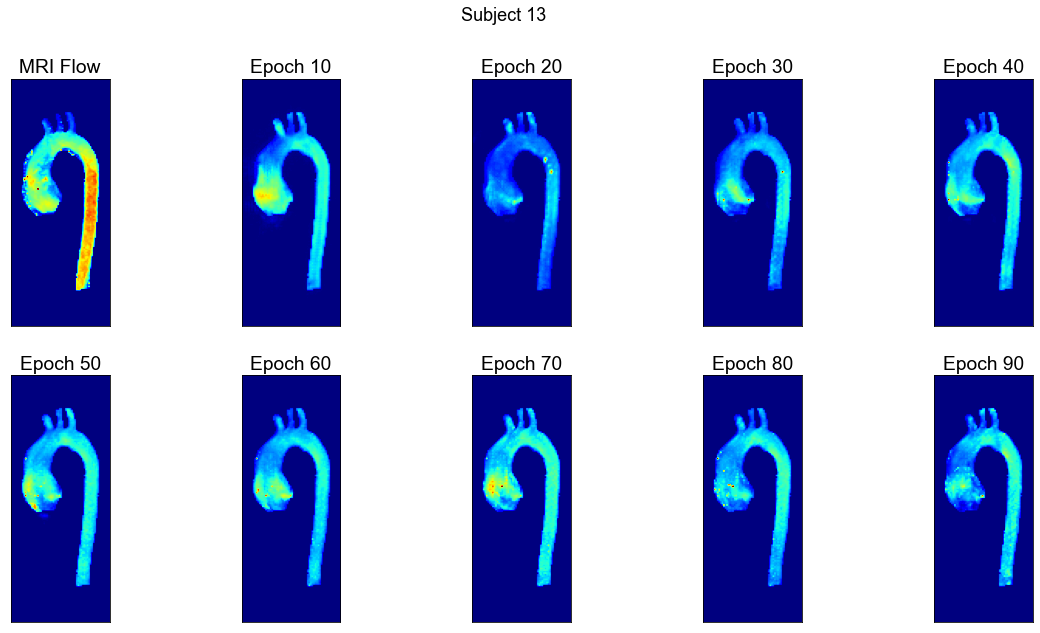

----------------------------------------------------------


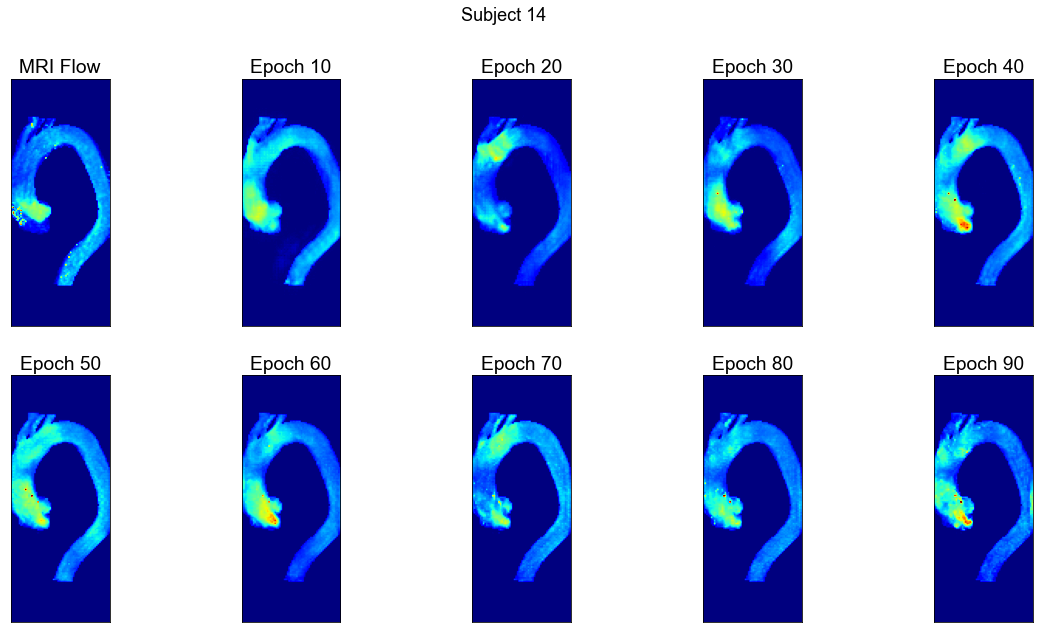

----------------------------------------------------------


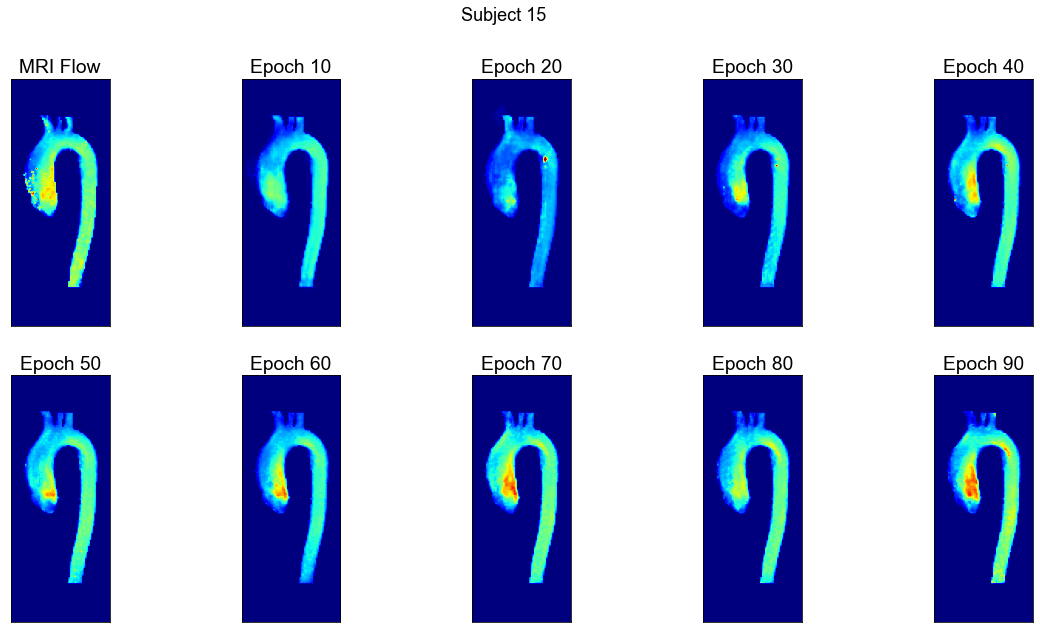

----------------------------------------------------------


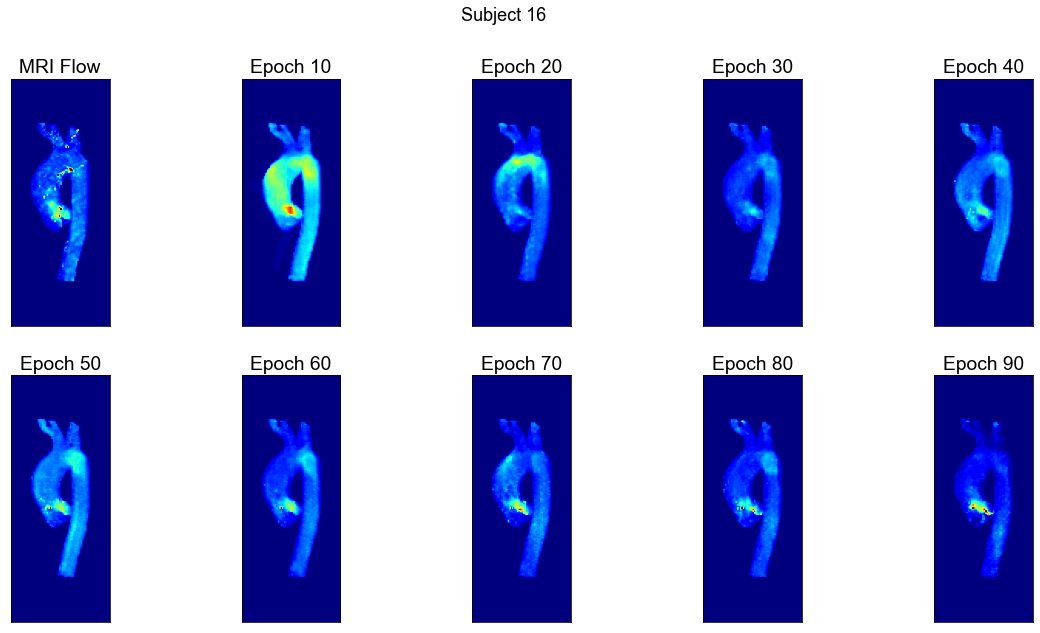

----------------------------------------------------------


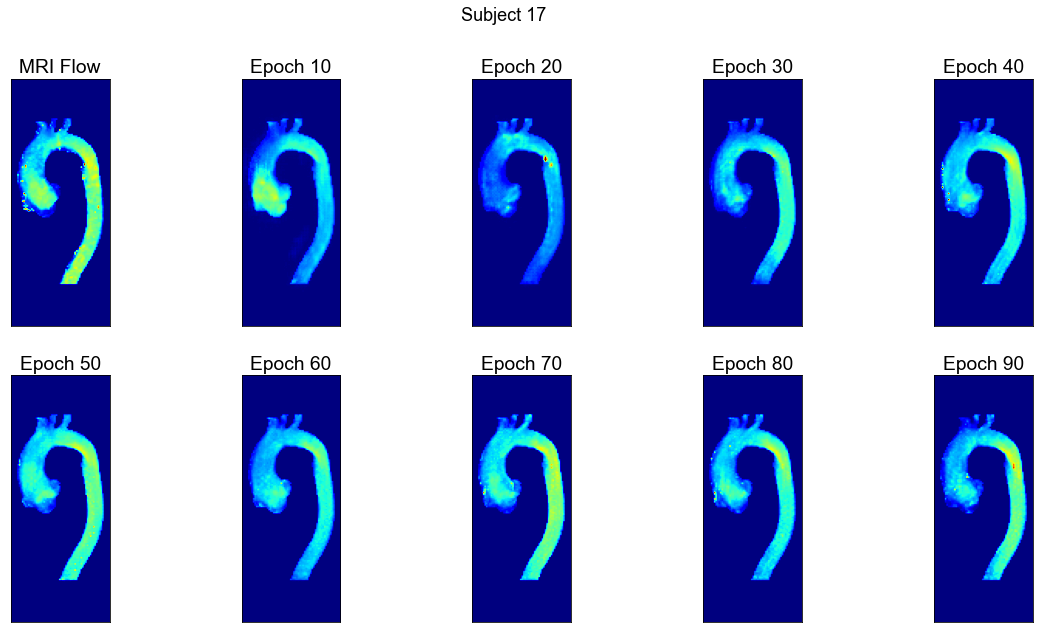

----------------------------------------------------------


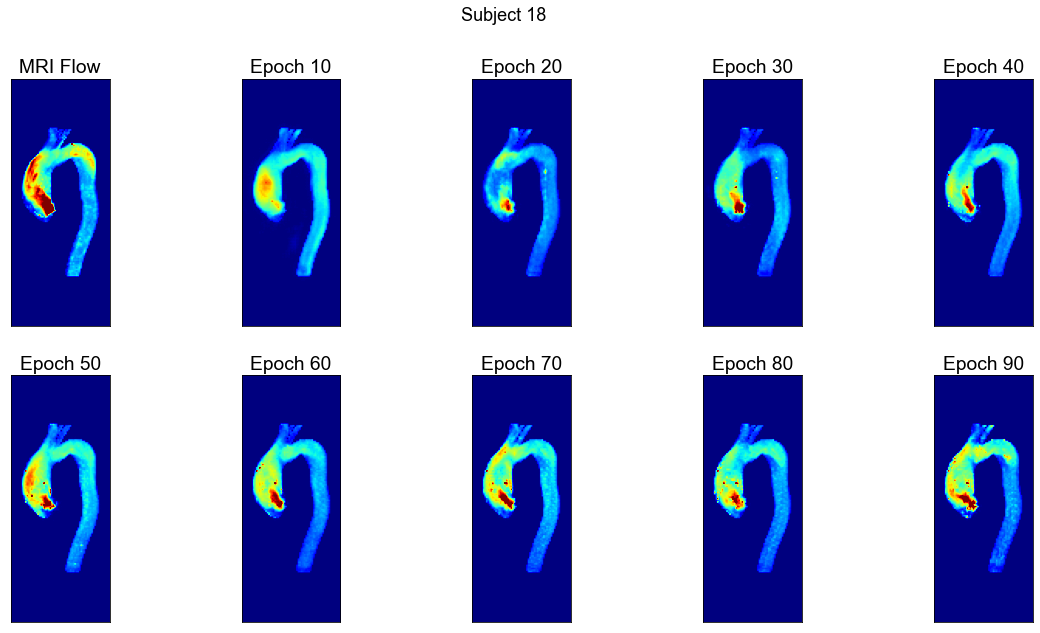

----------------------------------------------------------


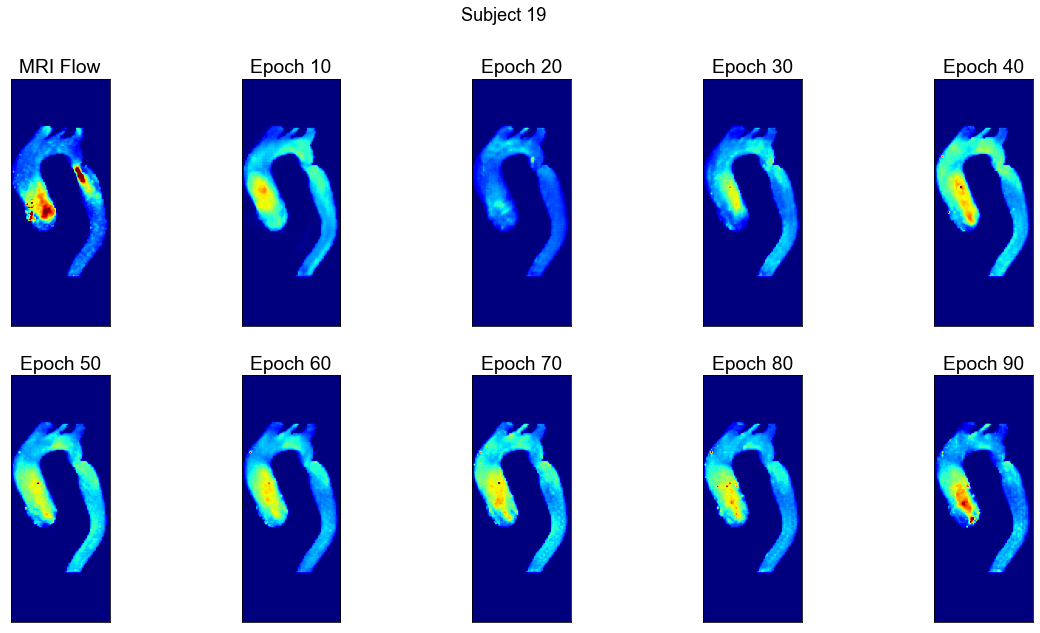

----------------------------------------------------------


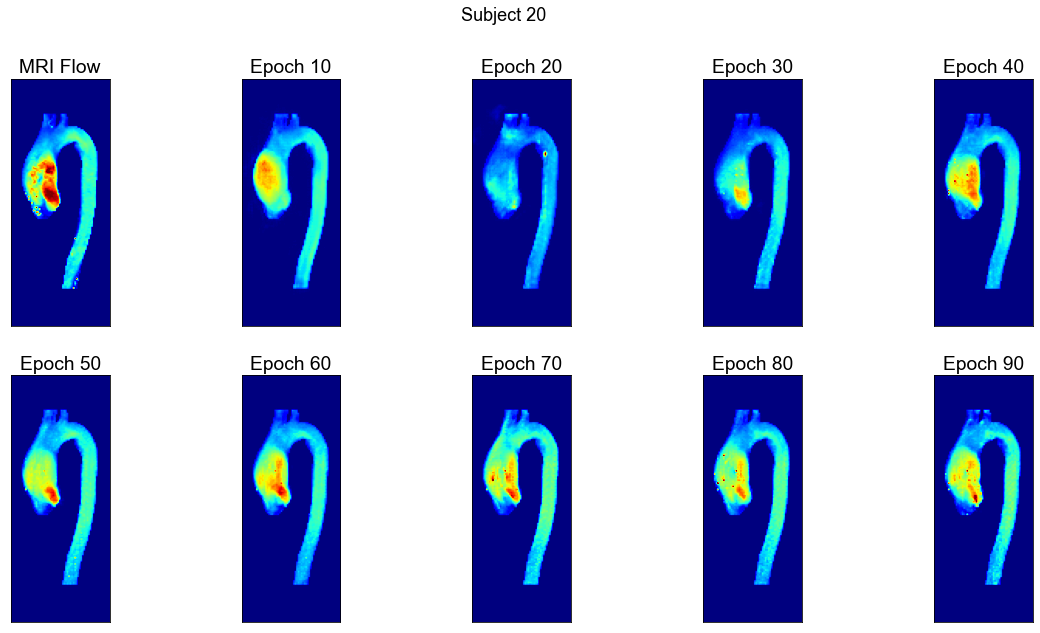

----------------------------------------------------------


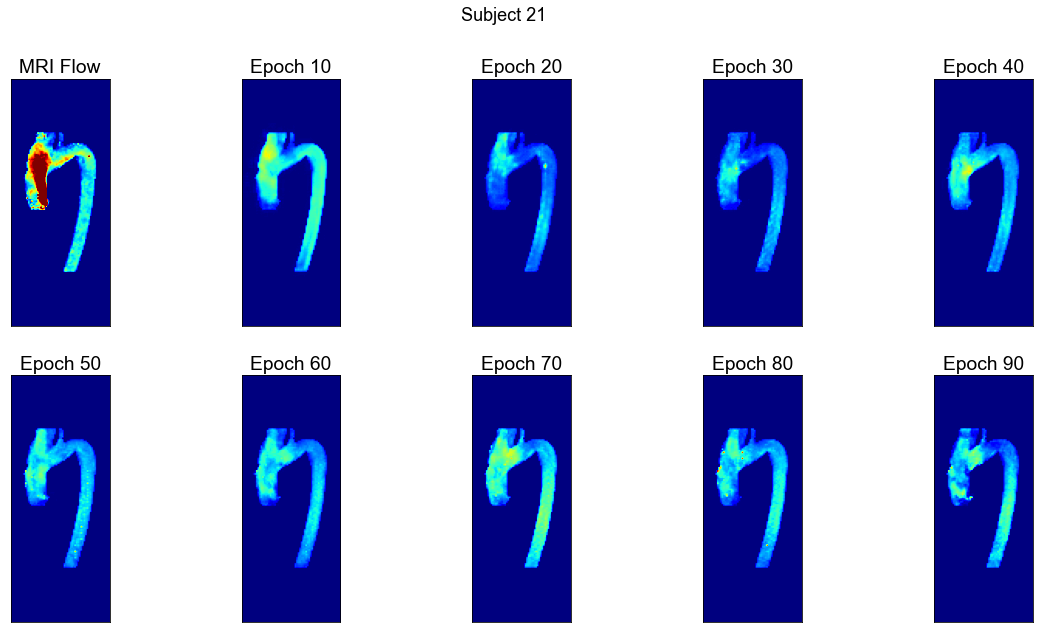

----------------------------------------------------------


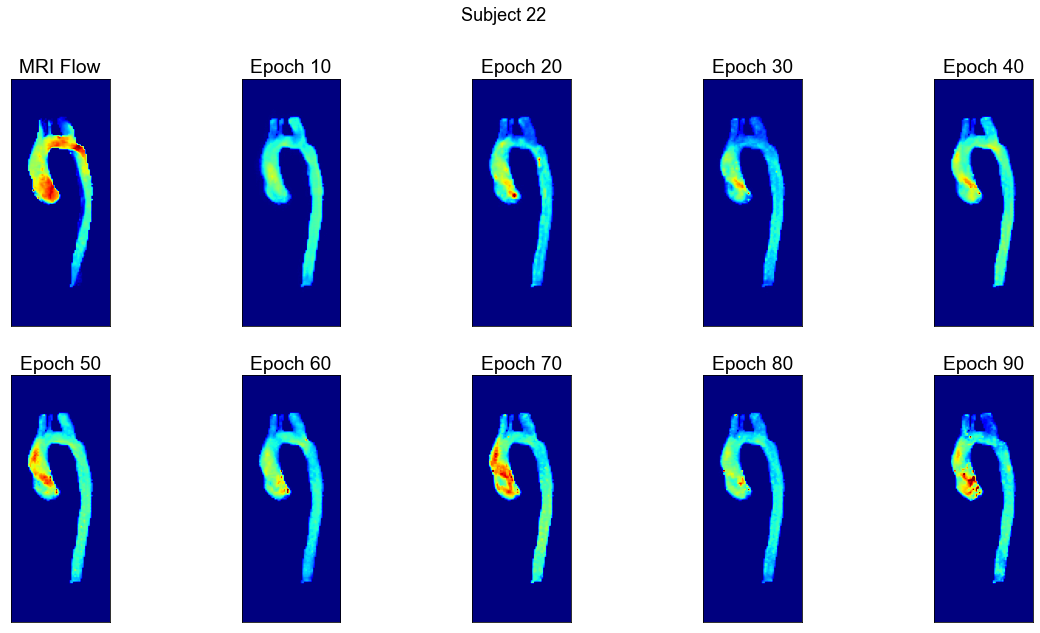

----------------------------------------------------------


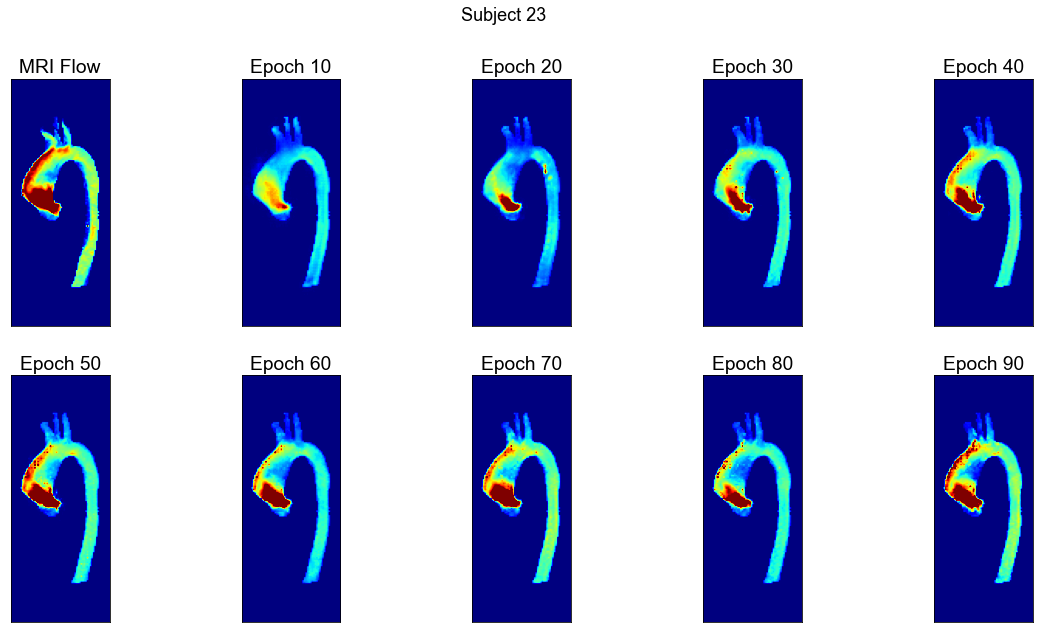

----------------------------------------------------------


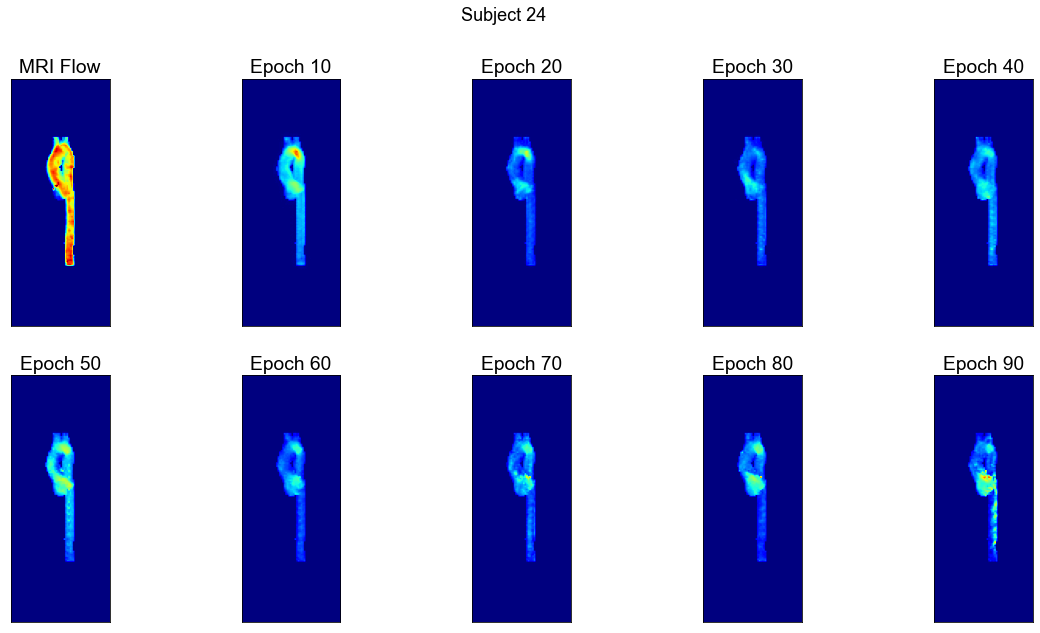

----------------------------------------------------------


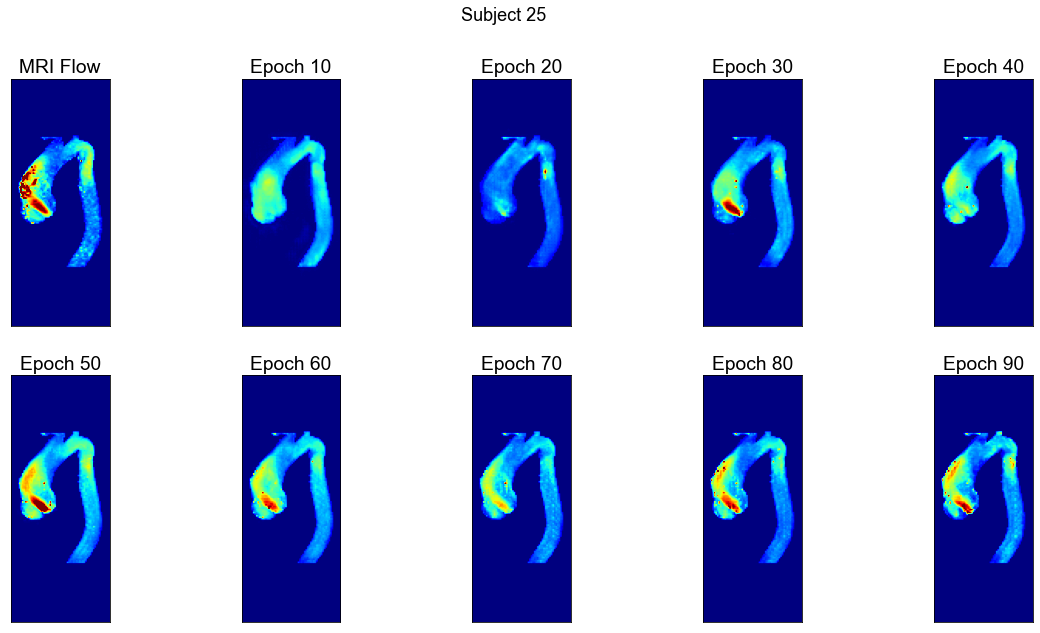

----------------------------------------------------------


In [63]:
# Set font properties
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 16

for jj, (anatomy, flow) in enumerate(dataset_test):
    # Reshape the input images A and B to the model's expected shape
    A = tf.reshape(anatomy, (1, height_crop_size, width_crop_size, slice_size, 1))
    B = np.squeeze(flow.numpy())
    
    # Initialize the figure and axis
    fig, axs = plt.subplots(2, 5, figsize=(20, 10))
    plt.suptitle(f'Subject {jj+1}', fontsize=18)
    axs = axs.ravel()

    # Iterate over the checkpoints
    for ii, ckpt_file in enumerate(checkpoint_files):
        # Create the checkpoint path by concatenating the checkpoint directory and the current checkpoint filename
        checkpoint_path = tf.io.gfile.join(checkpoint_dir, ckpt_file)
        # Restore the model's weights from the checkpoint
        checkpoint.restore(checkpoint_path)
        # Generate the transformed image A2B
        A2B = test_step(gen, A)
        # Convert the tensors to numpy arrays and remove the extra dimensions
        A2B = np.squeeze(A2B.numpy()) 
        # Check if the ii mod 10 is equal to zero
        if ii == 0:
            # Plot the image of A2B at the current subplot
            axs[ii].imshow(np.max(B, axis=2), cmap='jet', vmin=0, vmax=2)
            axs[ii].set_title('MRI Flow')
        else:
            axs[ii].imshow(np.max(A2B, axis=2), cmap='jet', vmin=0, vmax=2)
            axs[ii].set_title(f'Epoch {ckpt-1}')
        axs[ii].set_xticks([])
        axs[ii].set_yticks([])

    # Show the figure
    plt.show()
    fig.savefig(f'im_vs_epochs_{jj}.svg', bbox_inches='tight',facecolor=fig.get_facecolor())
    print('----------------------------------------------------------')